In [10]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

In [11]:
#general settings
LSST = True
#if not LSST redhsift kernel
chi0 = chi_cmb/6.
sigma_chi = chi_cmb/14.
bin_num = 'all'
z_source = z_cmb
chi_source = chi_z(z_source)
#put a number compatible with maximum of galaxy dis (see above)
chimax = max(chi_source,chi_z(5.))


if LSST:
    if chi_source==chi_cmb:
        file_ext = 'lsst%s_cmblens'%str(bin_num)
    else:
        file_ext = 'lsst%s_deltalens_z%s'%(str(bin_num),str(z_source*10))

else:
    if chi_source==chi_cmb:
        file_ext = 'gaussgal_chi0%d_sigmachi%d_cmblens'%(chi0,sigma_chi)
    else:
        file_ext = 'gaussgal_chi0%d_sigmachi%d_deltalens_z%s'%(chi0,sigma_chi,str(z_source*10)) 
print(file_ext)


params = {}
params['LSST'] = LSST
params['chi0'] = chi0
params['sigma_chi'] = sigma_chi
params['bin_num'] = bin_num
params['chimax'] = chimax
params['chisource'] = chi_source
params['zsource'] = z_source
params['ext'] = file_ext

pickle.dump(params,open('../settings/params_%s.pkl'%file_ext,'wb'))

pickle.load(open('../settings/params_%s.pkl'%file_ext,'rb'))



lsstall_cmblens


{'LSST': True,
 'bin_num': 'all',
 'chi0': 1569.0996594935225,
 'chimax': array(9414.597956961135),
 'chisource': array(9414.597956961135),
 'ext': 'lsstall_cmblens',
 'sigma_chi': 672.47128264008109,
 'zsource': 1088.6464513003543}

In [12]:
print('delta lensing with chimax %d'%chimax)
def lensing_kernel(xi):
    xmax = chi_source
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
    
if LSST:
    if bin_num == 'all':
        def galax_kernel(x):
            return lsst_kernel_cb(x)*simple_bias(x)
    else:
        def galax_kernel(x):
            return lsst_kernel_cbn[bin_num](x)*simple_bias(x)
else:
    kernel = Gauss_chi(chi0,sigma_chi)
    def galax_kernel(x):
        return kernel(x)*simple_bias(x)

print(galax_kernel(chimax))

delta lensing with chimax 9414
0.0


In [13]:
L = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)

### 1) Non-Limber Terms Equations 4.6-4.7

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{\delta\phi}(\chi',\chi'')\\
= 2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi W(\chi,\chi_{CMB}) \int_0^\chi \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{g\phi}(\chi'') $




In [14]:
chimaxs = np.load('../G_matrices/clphigalchimaxs_%s.npy'%file_ext)
clgphi  = np.load('../G_matrices/clphigal_%s.npy'%file_ext)
#check if chimaxs are in correct order


r2d, t2d = np.meshgrid(t_,t_)
np.prod((chimaxs==r2d*t2d*chimax))

1

In [15]:
clgphi_Chirag = np.load('../output/cm_clmesh/clphideltacmb_1plusz.npy')

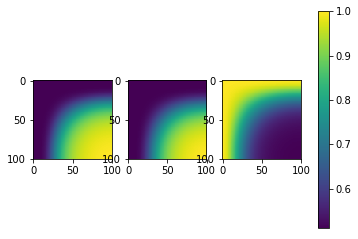

In [16]:
fig, ax = plt.subplots(ncols=3,nrows=1)
a = ax[0].imshow(clgphi_Chirag[10])
b = ax[1].imshow(clgphi[10])
c = ax[2].imshow(clgphi_Chirag[10]/clgphi[10])
fig.colorbar(c, ax=ax)


In [55]:
try:
    assert(False)
    _, M31b = np.load('../M_matrices/M31b_%s.npy'%str(file_ext))
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)
    
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clgphi_  = np.expand_dims(clgphi,-1)


    result   = np.zeros((len(ell_),len(ell_)))

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = inner_kernel(r2d*t2d*chimax,chimax*r2d)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax))*clgphi_[nn]

        chi2fac0  = chi2fac00

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I0_ltrc[ii])

    print(time.time()-begin)

    #- sign from going clphidelta
    M31b = -chimax * result*1./np.pi**2/2.*prefac**2/4.*2

    #first index L, second index l
    np.save('../M_matrices/M31b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M31b])
# to do: check if l grids are correct

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
364.340479136


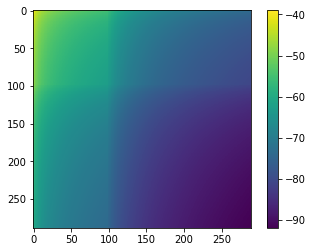

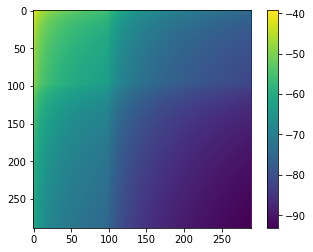

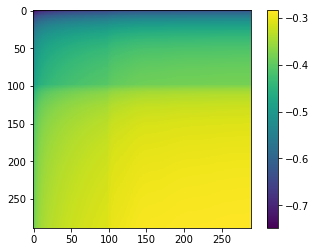

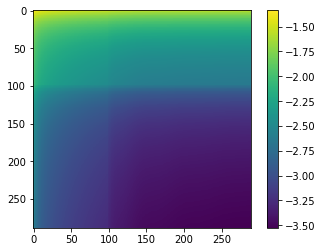

0.51824968926298853

In [19]:
MB1_Chirag = np.load('../output/cm_clmesh/cl31b_1plusz.npy')

M31b_spline = RectBivariateSpline(ell_,ell_,M31b)
plt.imshow(np.log(-M31b))
plt.colorbar()
plt.show()
plt.imshow(np.log(MB1_Chirag))
plt.colorbar()
plt.show()

plt.imshow((MB1_Chirag/M31b))
plt.colorbar()
plt.show()

plt.imshow((M31b/MB1_Chirag))
plt.colorbar()
plt.show()

np.mean(M31b/MB1_Chirag)
np.std(M31b/MB1_Chirag)

In [20]:
# Eq. 5.6



def l_integration_1(M,L,l):
    return L**2*np.trapz(l**5*M(L,l),l)/4./np.pi


In [21]:
res=[]
for LL in L:
    res+=[l_integration_1(M31b_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term3_%s.npy'%file_ext,[L,res])
term3 = res

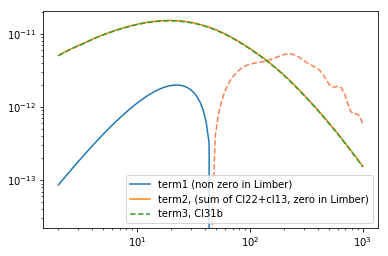

In [23]:
L1, term1 = np.load('../output/results/term1_%s.npy'%file_ext)
L2, term2 = np.load('../output/results/term2_%s.npy'%file_ext)

plt.loglog(L1,term1,label='term1 (non zero in Limber)')
plt.loglog(L1,-term1,c='coral',ls='--')
plt.loglog(L2,term2,label='term2, (sum of Cl22+cl13, zero in Limber)')

plt.loglog(L,-term3,label='term3, Cl31b',ls='--')
plt.legend()


Term 2:
$-2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\psi}(\chi'',\chi)   C_l^{\delta\phi}(\chi',\chi'')\\
= -2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi'  W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi') C_L^{\psi\phi}(\chi'')   C_l^{\delta_h \phi}(\chi',\chi'') $

In [24]:
#phi goes up to chi''
clphidelta  = np.load('../G_matrices/clphidelta_parallel_MB2_%s.npy'%file_ext)

#phi goes to chi_source
clphipsi    = np.load('../G_matrices/clpsiphi_parallel_MB2_%s.npy'%file_ext)

print(clphidelta.shape)
print(clphipsi.shape)

(289, 100, 100)
(289, 100, 100)


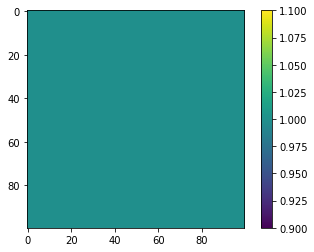

In [25]:
chimaxs = np.load('../G_matrices/clphidelta_parallel_MB2_chis_%s.npy'%file_ext)
r2d, t2d = np.meshgrid(t_,t_)
chimaxs3 = r2d*t2d*chimax
chimaxs2 =  t_.reshape(-1, 1)*t_.reshape(1, -1)*chimax
plt.imshow(chimaxs3/chimaxs)
plt.colorbar()
plt.show()


In [26]:
clphidelta_Chirag  = np.load('../output/cm_clmesh/cldeltachiphi.npy')
clphipsi_Chirag   = np.load('../output/cm_clmesh/clpsiphicmb.npy')

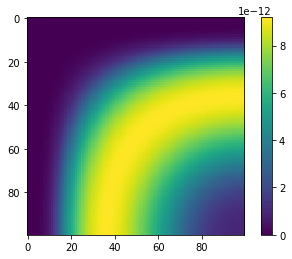

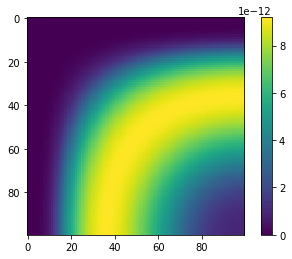

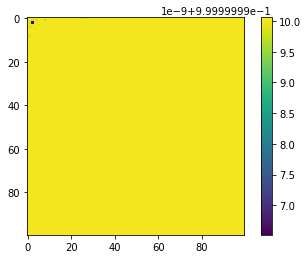

In [27]:
r2d, t2d = np.meshgrid(t_,t_)
plt.imshow(clphipsi[10])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(clphipsi_Chirag[10]*(1+z_chi(r2d*t2d*chimax)))
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(clphipsi_Chirag[10]*(1+z_chi(r2d*t2d*chimax))/clphipsi[10])
plt.colorbar()

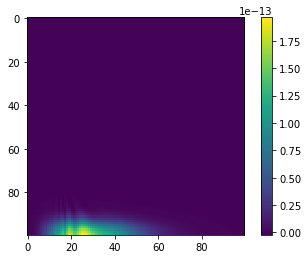

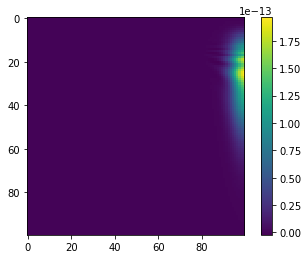

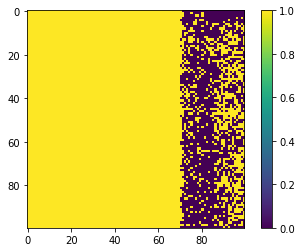

In [28]:
plt.imshow(clphidelta[100])
plt.colorbar()
plt.show()
plt.imshow(clphidelta_Chirag[100])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(clphidelta_Chirag[100]==clphidelta[100].T)
plt.colorbar()
plt.show()


In [35]:
try:
    _, M13b = np.load('../M_matrices/M13b_%s.npy'%str(file_ext))
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi)*(xmax > xi)

    kernel2 = inner_kernel
    kernel1 = galax_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)


    result   = np.zeros((len(ell_),len(ell_)))

    n = 0

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = kernel1(r2d*chimax)
        chi1fac0 = chi1fac0*(r2d*chimax)

        chi2fac0 = kernel2(r2d*t2d*chimax,chimax*r2d)*clphipsi[nn]
        chifacs  = w11*w12*chi1fac0*chi2fac0

        for ii  in range(len(ell_)):        
            result[nn][ii] = np.sum(chifacs*clphidelta[ii])

    #first index is L
    M13b = chimax*result/4.

    np.save('../M_matrices/M13b_%s.npy'%str(file_ext),[np.meshgrid(ell_),M13b])
    M13b_spline = RectBivariateSpline(ell_,ell_,M13b)

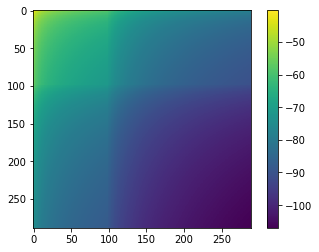

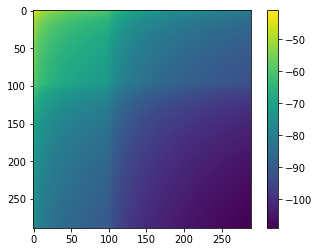

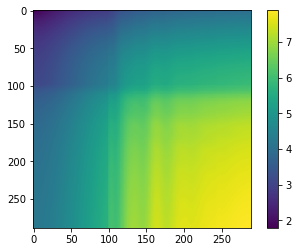

In [36]:
plt.imshow(np.log(M13b))
plt.colorbar()
plt.show()
MB_Chirag = np.load('../output/cm_clmesh/cl13b.npy')
plt.imshow(np.log(MB_Chirag))
plt.colorbar()
plt.show()
plt.imshow(M13b/MB_Chirag)
plt.colorbar()


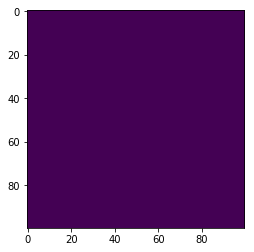

In [37]:
r1d, t1d = t_.reshape(1, -1), t_.reshape(-1, 1)
w11, w12 = w1.reshape(1, -1), w1.reshape(-1, 1)
grid = r1d*t1d*chi_cmb
plt.imshow(grid/(r2d*t2d*chimax))
plt.show()

In [56]:
#all minus signs cancel
def l_integration_2(M,L,l):
    return L**4*np.trapz(l**3*M(L,l),l)/4./np.pi #2 went into clphipsi

In [57]:
res=[]
for LL in L:
    res+=[l_integration_2(M13b_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term4_%s.npy'%file_ext,[L,res])
term4 = res

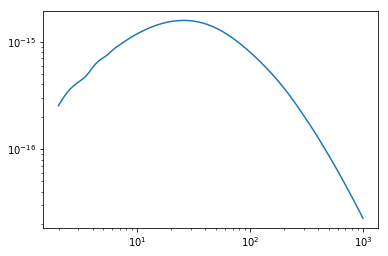

In [59]:
plt.loglog(L,res)

Term 3:
$C_{13,\rm{J}}^{(\kappa g)}(L) = - \frac{1}{2} \int \frac{d^2 l}{(2 \pi)^2} l^2 L^4 \int_0^{\chi_{max}} d \chi \, W_h(\chi) C_L^{\phi \phi}(\chi,\chi_{CMB}) C^{\phi\delta_h}_{l}(\chi)$


In [60]:
clphiphi_xi_xi_source = np.load('../G_matrices/clphiphi_parallel_chisource_%s.npy'%file_ext)


In [61]:
clphidelta = np.load('../G_matrices/clphidelta_%s.npy'%file_ext)
clphidelta_diag = np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    clphidelta_diag[:,ii] = clphidelta[:,ii,ii]

In [62]:
try:
    assert(False)
    _, M13J = np.load('../M_matrices/M13J_%s.npy'%str(file_ext))
    M13J_spline = RectBivariateSpline(ell_,ell_,M13J)
except:
    kernel1 = galax_kernel
    result  = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = -chimax*np.sum(w1*kernel1(t_*chimax)*clphidelta_diag[jj]*clphiphi_xi_xi_source[ii])/2.
    np.save('../M_matrices/M13J_%s.npy'%str(file_ext),[np.meshgrid(ell_),result])
    M13J = -0.5*result
    M13J_spline = RectBivariateSpline(ell_,ell_,M13J)

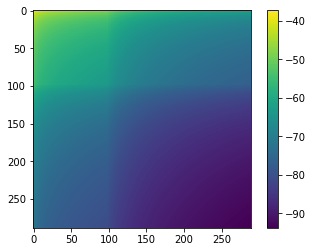

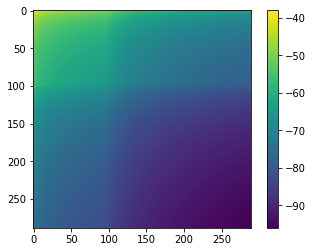

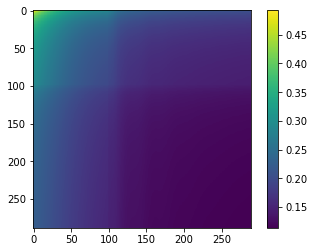

In [44]:
res_chirag = np.load('../output/cm_clmesh/cl13j.npy')
plt.imshow(np.log(-M13J))
plt.colorbar()
plt.show()
plt.imshow(np.log(res_chirag))
plt.colorbar()
plt.show()
plt.imshow((-res_chirag/M13J))
plt.colorbar()
plt.show()

In [45]:
def l_integration_3(M,L,l):
    return L**4*np.trapz(l**3*M(L,l),l)/2./np.pi

In [46]:
res=[]
for LL in L:
    res+=[l_integration_3(M13J_spline,LL,l)]
res = np.asarray(res)
res = res[:,0]
np.save('../output/results/term5_%s.npy'%file_ext,[L,res])
term5 = res

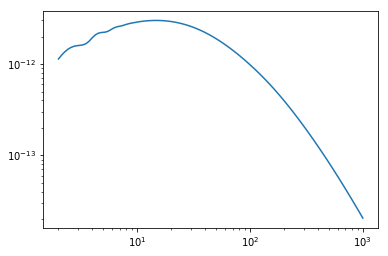

In [47]:
plt.figure()
plt.loglog(L,term5)

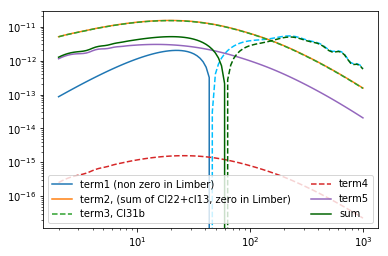

In [54]:

plt.loglog(L1, term1,label='term1 (non zero in Limber)')
plt.loglog(L2,-term1,c='deepskyblue',ls='--')
plt.loglog(L2, term2,label='term2, (sum of Cl22+cl13, zero in Limber)')
plt.loglog(L, -term3,label='term3, Cl31b',ls='--')
plt.loglog(L, -term4,label='term4',ls='--')
plt.loglog(L,  term5,label='term5')
assert(np.all(L1==L2))
assert(np.all(L==L2))
plt.loglog(L, term1+term2+term3+term4+term5,label='sum',color='darkgreen')
plt.loglog(L, -(term1+term2+term3+term4+term5),ls='--',color='darkgreen')
plt.legend(loc='lower right',ncol=2)


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False